# June 6-8, 2022: simulated data: wss noise
1. wide-sense stationary additive noise over the mean time series of each condition
2. compare model performances

In [11]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
# import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob

# synthetic data generation
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

# explanation tools
import captum

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions

# cuda device
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

True
Using cuda:1 device


In [2]:
def plot_roi_time_series(X, y, savefig=False, fig_file=None):
    X_conds = {}
    for label in args.LABELS:
        idx = y[:, 0] == label
        X_conds[f"{label}_m"] = np.mean(X[idx, :, :], axis=0)
        X_conds[f"{label}_s"] = 1.96 * np.std(X[idx, :], axis=0) / np.sqrt(idx.shape[0])

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(X.shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = 17, 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi_name in enumerate(roi_names):
        ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

        ax.set_title(f"{roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[f"{label}_m"][:, idx_roi]
            ts_std = X_conds[f"{label}_s"][:, idx_roi]

            ax.plot(ts_mean, color=colors[label], label=names[label])

            ax.fill_between(
                time, 
                (ts_mean - ts_std), 
                (ts_mean + ts_std),
                alpha=0.3, color=colors[label],
            )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

In [3]:
def plot_samples(X, y, savefig=False, fig_file=None):
    X_conds = {}
    for label in args.LABELS:
        idx = y[:, 0] == label
        X_conds[label] = X[idx]

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(X.shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = 17, 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi_name in enumerate(roi_names):
        ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

        ax.set_title(f"{roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[label][:10, :, idx_roi].T

            ax.plot(ts_mean, color=colors[label], alpha=0.3)

        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        # ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

In [4]:
normalize = lambda z: (z - np.mean(z)) / np.std(z)

def get_data(data_df, subj_idx_list):

    X, y = [], []
    for idx_row in tqdm(subj_idx_list):
        subj, ts, targets = data_df.iloc[idx_row]

        for label in args.LABELS:
            contig_regions = dataset_utils.contiguous_regions(targets == label)

            for region in contig_regions:
                X.append(ts[region[0]: region[1], :])
                y.append(targets[region[0]: region[1]])

    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)

    for idx_roi in np.arange(X.shape[-1]):
        X[:, :, idx_roi] = normalize(np.squeeze(X[:, :, idx_roi]))
    
    return X, y #torch.FloatTensor(X).to(device=device), torch.LongTensor(y).to(device=device)

In [5]:
'''
dataframe
'''
max_data_path = f"{proj_dir}/data/max/data_df.pkl"
with open(max_data_path, 'rb') as f:
    max_data_df = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

# data
args.num_subjects = len(max_data_df)
args.num_train = round(0.4 * args.num_subjects)
args.num_valid = round(0.3 * args.num_subjects)
args.num_test = args.num_subjects - args.num_train - args.num_valid

'''
generate dataset for the model
'''
subject_idx_list = np.arange(args.num_subjects)
# random.Random(args.SEED).shuffle(subject_idx_list)

train_idx_list = subject_idx_list[:args.num_train]
valid_idx_list = subject_idx_list[args.num_train : args.num_train + args.num_valid]
test_idx_list = subject_idx_list[args.num_train + args.num_valid:]

(X_train, y_train) = get_data(max_data_df, train_idx_list)
(X_valid, y_valid) = get_data(max_data_df, valid_idx_list) 
(X_test, y_test) = get_data(max_data_df, test_idx_list)

100%|██████████| 32/32 [00:00<00:00, 3426.19it/s]


In [16]:
X, y = np.copy(X_train), np.copy(y_train)

In [19]:
for label in args.LABELS:
    idx = y[:, 0] == label
    for idx_tp in np.arange(X.shape[1]):
        X[idx, idx_tp, :] = normalize(X[idx, idx_tp, :])

# b, t, r = X.shape
# X_ = np.reshape(X, newshape=(b*t, r))
# y_ = np.reshape(y, newshape=(b*t))

1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999


/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


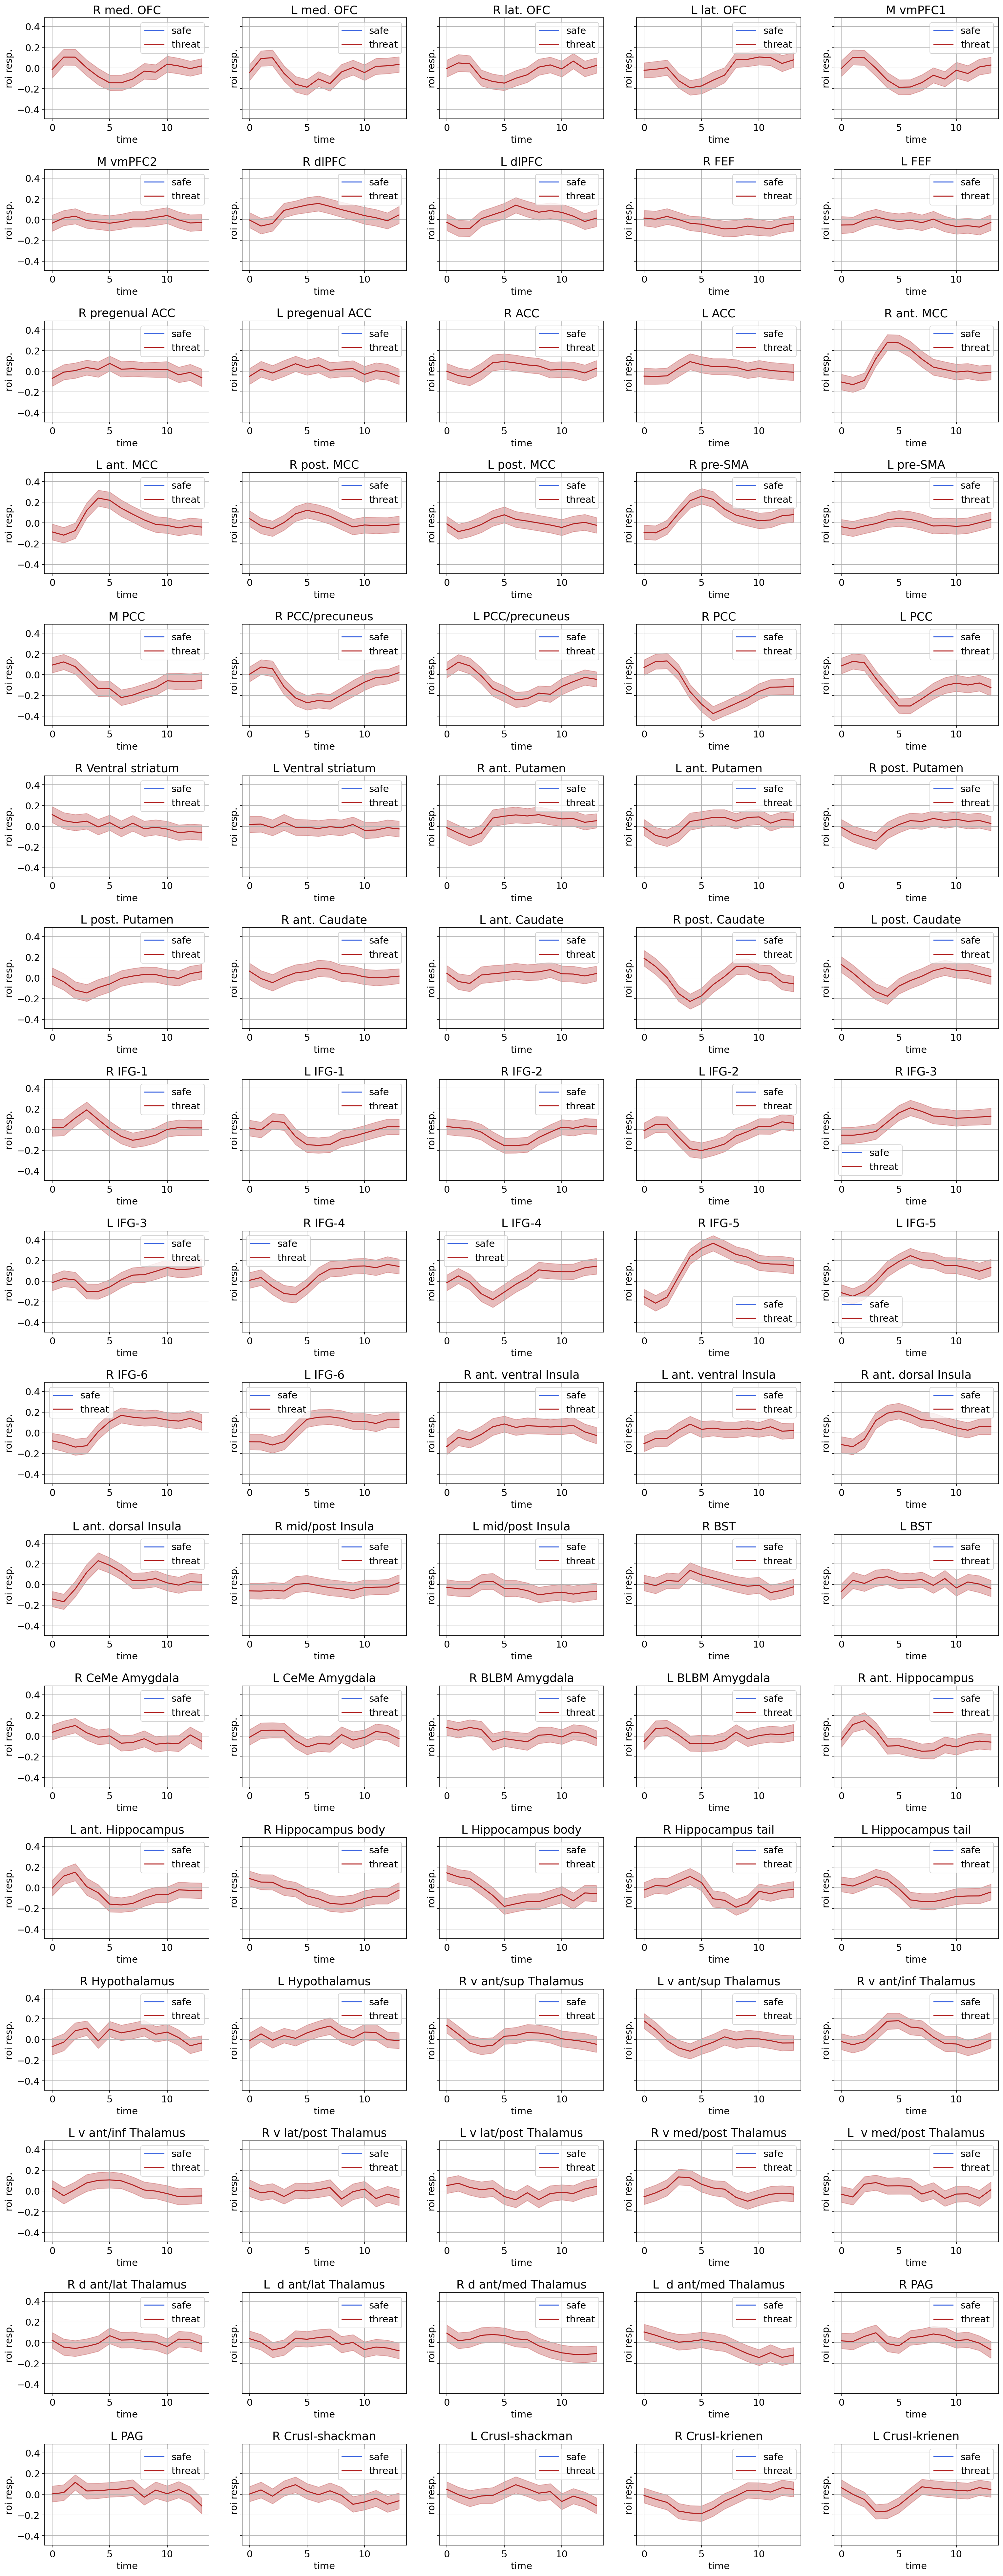

In [25]:
plot_roi_time_series(X, y)